In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, shutil, sys
from datetime import datetime
#import AnaUtils as mc
import configparser
import argparse
import pennylane as qml
import numpy as np
from pennylane.templates import QAOAEmbedding, StronglyEntanglingLayers
from pennylane.optimize import AdagradOptimizer,AdamOptimizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import pandas as pd
from os.path import basename
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import metrics
from IPython.display import Image

Import some datasets

In [31]:
jet_df = pd.read_csv('prova.csv')
jet_df.set_index('idx', inplace=True)

In [32]:
print(jet_df)

                 Jet_foundMuon  Jet_muon_q  Jet_muon_PT  Jet_LABEL  \
idx                                                                  
67534_bbdw50V2           False           0        -99.0         -1   
206375_bbup50V2          False           0        -99.0          1   
210480_bbup20V2          False           0        -99.0         -1   
152795_bbdw20V2          False           0        -99.0         -1   
70915_bbup50V2           False           0        -99.0         -1   
...                        ...         ...          ...        ...   
29075_bbup50V2           False           0        -99.0          1   
1599_bbdw50V2            False           0        -99.0         -1   
201530_bbdw20V2          False           0        -99.0          1   
11186_bbdw15V2           False           0        -99.0         -1   
124949_bbup50V2          False           0        -99.0         -1   

                       Jet_PT   Jet_ETA   Jet_PHI   weights  mu_Q  mu_pTrel  \
idx       

In [33]:
prediction = pd.read_csv('/lhcbdata/users/zuliani/lhcb_mljet/BBAsym/results/article/results/DN_TestProb.csv')
prediction.set_index('idx', inplace=True)
print(prediction)
prob = prediction['prob']
jet_df['prob'] = prob

                     prob
idx                      
67534_bbdw50V2   0.401224
206375_bbup50V2  0.359896
210480_bbup20V2  0.642130
152795_bbdw20V2  0.416559
70915_bbup50V2   0.409409
...                   ...
29075_bbup50V2   0.484026
1599_bbdw50V2    0.427681
201530_bbdw20V2  0.589480
11186_bbdw15V2   0.394622
124949_bbup50V2  0.431559

[295218 rows x 1 columns]


In [34]:
print(jet_df)

                 Jet_foundMuon  Jet_muon_q  Jet_muon_PT  Jet_LABEL  \
idx                                                                  
67534_bbdw50V2           False           0        -99.0         -1   
206375_bbup50V2          False           0        -99.0          1   
210480_bbup20V2          False           0        -99.0         -1   
152795_bbdw20V2          False           0        -99.0         -1   
70915_bbup50V2           False           0        -99.0         -1   
...                        ...         ...          ...        ...   
29075_bbup50V2           False           0        -99.0          1   
1599_bbdw50V2            False           0        -99.0         -1   
201530_bbdw20V2          False           0        -99.0          1   
11186_bbdw15V2           False           0        -99.0         -1   
124949_bbup50V2          False           0        -99.0         -1   

                       Jet_PT   Jet_ETA   Jet_PHI   weights  mu_Q  mu_pTrel  \
idx       

In [35]:
def MC_ApplyAlgTagging(df, netype="Quantum", mu_cut=5000):
    """
    Performs the MLAlg tagging for each jet, and applies a probabilities R/L cuts or a muonPT cut.
    netype is used to identify columns name. 
    -> Right cut is for label 1, left cut for label 0 

    COLUMNS REQUIRED          COLUMNS ADDED
    Jet_foundMuon (if MuTag)  "Jet_%s_Charge"%nettype (0: Not tagged)    
    Jet_muon_q    (if MuTag)
    Jet_muon_PT   (if MuTag)
    Jet_%sProb"%netype       
    """
    if (netype=="MuTag"):
      df['Jet_MuTag_Charge'] = 0
      tt_Jet = (df['Jet_foundMuon'] == 1) & (df['Jet_muon_PT'] > mu_cut)
      df.loc[tt_Jet, 'Jet_MuTag_Charge'] = df.loc[tt_Jet].Jet_muon_q
    else:
      df['Jet_%s_Charge'%netype] = 0
      tt_Jet_1 = (df["Jet_%sProb"%netype] > 0.5)
      tt_Jet_0 = (df["Jet_%sProb"%netype] < 0.5)
      df.loc[tt_Jet_1,'Jet_%s_Charge'%netype] =  1
      df.loc[tt_Jet_0,'Jet_%s_Charge'%netype] =  -1

def MC_ApplyAlgChecking(df, netype="Quantum"):
    """
    Checks the result of the Alg tagging by comparing the guess with the MC-truth.
    netype is used to identify columns name. 

    COLUMNS REQUIRED           COLUMNS ADDED

    "Jet_%s_Charge"%netype     "Jet_%s_Check"%netype     
    Jet_MATCHED_CHARGE
    """
    df['Jet_%s_Check'%netype] = 0

    tt_correct_jet = (df['Jet_%s_Charge'%netype] != 0) & (df['Jet_%s_Charge'%netype] == df.Jet_MATCHED_CHARGE)
    tt_notcorrect_jet = (df['Jet_%s_Charge'%netype] != 0) & (df['Jet_%s_Charge'%netype] != df.Jet_MATCHED_CHARGE)

    df.loc[tt_correct_jet, 'Jet_%s_Check'%netype] = 1
    df.loc[tt_notcorrect_jet, 'Jet_%s_Check'%netype] = -1

In [36]:
jet_df.rename(columns={"Jet_LABEL": "Jet_MATCHED_CHARGE"}, inplace=True)
jet_df.rename(columns={"prob": "Jet_QuantumProb"}, inplace=True)
MC_ApplyAlgTagging(jet_df, "Quantum")
MC_ApplyAlgChecking(jet_df, "Quantum")
print(jet_df)

                 Jet_foundMuon  Jet_muon_q  Jet_muon_PT  Jet_MATCHED_CHARGE  \
idx                                                                           
67534_bbdw50V2           False           0        -99.0                  -1   
206375_bbup50V2          False           0        -99.0                   1   
210480_bbup20V2          False           0        -99.0                  -1   
152795_bbdw20V2          False           0        -99.0                  -1   
70915_bbup50V2           False           0        -99.0                  -1   
...                        ...         ...          ...                 ...   
29075_bbup50V2           False           0        -99.0                   1   
1599_bbdw50V2            False           0        -99.0                  -1   
201530_bbdw20V2          False           0        -99.0                   1   
11186_bbdw15V2           False           0        -99.0                  -1   
124949_bbup50V2          False           0        -9

In [37]:
def MC_GetAlgPerformances(jet_df, netype="Quantum"):
    """
    Extract Alg performance and associated uncertainties.
    netype is used to identify columns name.

    COLUMNS REQUIRED
    'Jet_%s_Check'%netype
    """
    N_tot = len(jet_df)

    N_tag = jet_df['Jet_%s_Check'%netype].value_counts()[1] + jet_df['Jet_%s_Check'%netype].value_counts()[-1]
    N_wrong = jet_df['Jet_%s_Check'%netype].value_counts()[-1]

    #Efficiency
    eps_eff = float(N_tag)/N_tot
    err_eps_eff = np.sqrt(eps_eff*(1-eps_eff)/N_tot)
    #Omega
    omega = float(N_wrong)/(N_tag)
    err_omega  = np.sqrt(omega*(1-omega)/N_tag)

    #Accuracy
    accuracy = 1- omega
    
    #Tagging Power
    eps_tag = (eps_eff * (1-2*omega)**2)
    #err_eps_tag = np.sqrt((N_tot*(eps_eff)*(1-eps_eff)) * Deps_DNtag(N_tot,N_wrong,N_tag)**2 + (N_tag*(omega)*(1-omega)) * Deps_DNw(N_tot,N_wrong,N_tag)**2)
    err_eps_tag = 0
    #print('tagging power = %s'%eps_tag)
    
    return eps_eff,omega,eps_tag,err_eps_eff,err_omega,err_eps_tag,N_tot,accuracy

In [38]:
bin_centers = []
half_widths = []

omegas = []
err_omegas = []
effs = []
err_effs = []
ptags = []
err_ptags = []
tot = []
accuracies = []

def MCAnalysis(jet_df, netype="Quantum", nbins=8, basepath="", legend=True):
    '''
    Performs the algorithms evaluation
    '''

    # Discretize variable into equal-sized buckets using jet PT
    out,bins = pd.qcut(jet_df.Jet_PT,nbins,retbins=True,labels=False)


    for i in range(nbins):
        bin_center = float((bins[i] + bins[i+1])/2)/1000
        half_width = float((bins[i+1] - bins[i])/2)/1000
        bin_centers.append(bin_center)
        half_widths.append(half_width)
    
        eps_eff,omega,eps_tag,err_eps_eff,err_omega,err_eps_tag,N_tot,accuracy = MC_GetAlgPerformances(jet_df[out == i], netype)
        omegas.append(omega*100)
        err_omegas.append(err_omega*100)
        ptags.append(eps_tag*100)
        err_ptags.append(err_eps_tag*100)
        effs.append(eps_eff*100)
        err_effs.append(err_eps_eff*100)

 
    fig = plt.figure(figsize=(6,6))
    plt.errorbar(bin_centers, ptags, xerr=half_widths, yerr=err_ptags, fmt='o', capsize=2, ms=8)
  
    #plt.xticks(np.arange(20,101, step=80))
    #plt.yticks(np.arange(1,40, step=4))
    plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    plt.ylabel("$\mathrm{\epsilon_{tag} \ (\%)}$")

    plt.minorticks_on()
    plt.figtext(0.530,0.360,"LHCb Simulation\nOpen Data", ma='right', fontsize=18)

    fig.savefig("./TagPower_%s.png"%(netype), bbox_inches='tight')
    plt.close()

    fig = plt.figure(figsize=(6,6))
    plt.errorbar(bin_centers, effs, xerr=half_widths, yerr=err_effs, fmt='o', capsize=2, ms=8)
  
    #plt.xticks(np.arange(20,101, step=80))
    #plt.yticks(np.arange(1,40, step=4))
    plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    plt.ylabel("$\mathrm{\epsilon_{tag} \ (\%)}$")

    plt.minorticks_on()
    plt.figtext(0.530,0.360,"LHCb Simulation\nOpen Data", ma='right', fontsize=18)

    fig.savefig("./efficiency_%s.png"%(netype), bbox_inches='tight')
    plt.close()




In [39]:
MCAnalysis(jet_df)

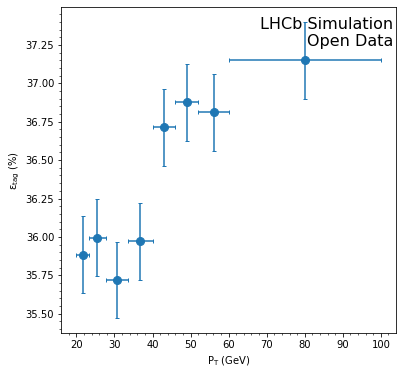

In [40]:
Image(filename='mistag_Quantum.png')

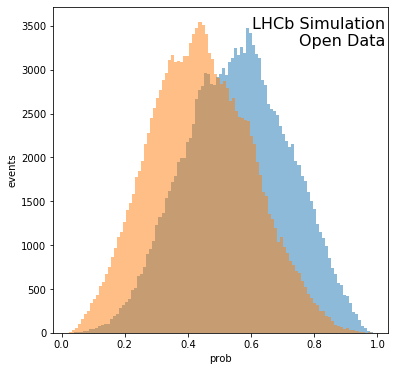

In [41]:
fig = plt.figure(figsize=(6,6))

plt.xlabel("prob")
plt.ylabel("events")

plt.hist(jet_df.loc[jet_df['Jet_MATCHED_CHARGE'] == 1, 'Jet_QuantumProb'], bins=100, alpha=0.5, label='b')
plt.hist(jet_df.loc[jet_df['Jet_MATCHED_CHARGE'] == -1, 'Jet_QuantumProb'], bins=100, alpha=0.5, label='bbar')

#plt.minorticks_on()
plt.figtext(0.585,0.790,"LHCb Simulation\nOpen Data", ma='right', fontsize=16)

#fig.savefig("./prob.png", bbox_inches='tight')
plt.show()